In [2]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# VEST AL 2016
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Alabama Secretary of State Elections Division (https://www.sos.alabama.gov/alabama-votes/voter/election-data). 

Incorrect or incomplete data was replaced using the county canvass reports for the following counties: Blount, Bullock, Dallas, Escambia, Greene, Hale, Jackson, Jefferson, Lamar, Lawrence, Marion, Pickens, Randolph, Russell, St. Clair, Shelby, Washington, Wilcox.

#### Processing
Absentee and provisional ballots were reported countywide in all counties. These were distributed by candidate to precincts based on their share of the precinct-level reported vote. Mobile County also reported only countywide totals for write in votes. These were distributed to precincts based on the difference between the number of ballots cast and the total votes reported for named candidates.

Note that the precinct results from DeKalb County add up to a higher total number of votes than the countywide totals certified by the state canvass. At the presidential level the difference is: Clinton (D) 60, Trump (R) 374, Johnson (L) 11, Stein (G) 4, Write In 3.


### Shapefiles

#### Sources
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

### Processing
Precinct boundaries were adjusted as appropriate to align with county maps, municipal boundaries, or commission districts. Precinct boundaries throughout the state were further reviewed with the voter registration file in effect for the November 2016 general election. Voting districts in nearly all counties were edited accordingly to align with reporting units in the 2016 election results. In many counties the resulting boundaries bear little resemblance to the 2020 Census VTDs. As these boundary revisions were so extensive only splits and merges are specified below by precinct.

Many precincts have outdated names in the Census VTDs. The Census VTDs also have at least some precinct names in wrong locations for the following counties: Clarke, Clay, Cleburne, Conecuh, Dallas, Escambia, Geneva, Greene, Jefferson, Lauderdale, Limestone, Marion, Marshall, Monroe, Perry, Randolph, Russell, Tallapoosa, Walker, Washington, Wilcox. Moreover, many precinct numbers and consequently the VTD GeoIDs are also incorrect throughout much of the state in the Census shapefiles. All precinct names and numbers have been edited to match the 2016 voter file.

The following splits and merges were made to align voting district boundaries with reporting units in the 2016 election results.

- Autauga: Merge Boone's Chapel/County Line
- Barbour: Split Eufaula between Bevill/CC/Fellowship/McCoo/Sanford/WB
- Calhoun: Add precinct splits to Beats 1, 4, 5, 9, 12, 13, 15, 19, 22
- Cherokee: Split Friendship/Mt Calvary, McCord's/Rock Run, Mt Weisner/VFD #2
- Choctaw: Split Cromwell/Halsell/Intersection
- Clarke: Split Antioch/Grove Hill/Helwestern, Choctaw Bluff/Gainstown, Grove Hill NG/Whatley, Jackson/Skipper, Springfield/Thomasville; Merge Fulton FS/CH
- Covington: Split Heath/Straughn, Pleasant Home/Wing
- Cullman: Split Cullman City Hall/Civic Ctr/Conf Room/Courthouse
- Dallas: Merge Marion Jct/New Friendship
- Elmore: Merge Grandview Pines/Nazarene
- Fayette: Split Browns Glen Allen/Whites Chapel, Cole Killingsworth/New River, Elm Grove/Studdards, Fayette CC/Covin/YC, Lee-Belk/Oak Ridge
- Geneva: Split Bellwood/Chancellor, Flat Creek/Hacoda, Geneva CC/CH/CO/FC/NG, Hughes VH/Malvern, Lowery/Revels, Piney Grove/Samson/Samson Masonic, Slocomb/Tate
- Houston: Split Enterprise/Lovetown; Merge Mt Gilead/Water & Electric
- Jackson: Split Holly Springs/Pleasant Groves
- Jefferson: Split 1350/1400 CJ Donald/Fairfield; Merge 2350/5270 as Oxmoor Valley, 3010/3015 as Hunter St
- Lee: Split Boykin/National Guard
- Marengo: Split Aimwell/Sweet Water, Taylorville/Thomaston
- Marion: Split Kimbrough N/S; Merge Hamilton N/S as ET Sims
- Marshall: Split Arab Comm Ctr/Rec Ctr, Guntersville/Warrenton
- Monroe: Split Chrysler/Mineola, Coleman/Excel, Franklin/Wainwright, Peterman/Philadelphia
- Randolph: Split Bethel/Moores/Woodland, Cavers/Swagg, Corinth/Morrison, Midway/New Hope/Wedowee, Omaha/Tin Shop/Wehadkee, Rock Mills/Wilson
- Russell: Split Courthouse/Golden Acres
- Tallapoosa: Split Cooper/Duncan/Moncrief; Merge New Paces 901/902 to match county shapefile
- Wilcox: Split National Guard Camden, Pine Apple Comm Ctr, Pine Apple AWIN, St Paul Church
- Winston: Split Addison/Upshaw, Delmar/Natural Bridge, Haleyville/Neighborhood/Pebble/Waldrop, Lynn/Old Union, Nesmith/Helicon


# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [3]:
vest_al_16 = gp.read_file("./raw-from-source/VEST/al_2016/al_2016.shp")

In [4]:
vest_al_16.crs

{'init': 'epsg:4269'}

<AxesSubplot:>

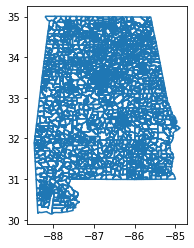

In [5]:
vest_al_16.boundary.plot()

In [6]:
vest_al_16.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST16', 'GEOID16', 'NAME16', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRSHE',
       'G16USSDCRU', 'G16USSOWRI', 'G16SSCRBOL', 'G16SSCOWRI', 'G16SSCRWIS',
       'G16SSCOWR2', 'G16SSCRPAR', 'G16SSCOWR3', 'G16PSCRCAV', 'G16PSCOWRI',
       'geometry'],
      dtype='object')

In [7]:
vest_al_16.head(5)

,STATEFP20,COUNTYFP20,VTDST16,GEOID16,NAME16,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,...,G16USSOWRI,G16SSCRBOL,G16SSCOWRI,G16SSCRWIS,G16SSCOWR2,G16SSCRPAR,G16SSCOWR3,G16PSCRCAV,G16PSCOWRI,geometry
0,01,013,000100,01013000100,Monterey School House,22,33,2,0,0,...,0,22,1,22,1,22,1,21,1,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."
1,01,013,000181,01013000181,Bolling,83,40,2,0,0,...,0,87,0,85,0,87,0,87,1,"POLYGON ((-86.71867 31.73289, -86.71864 31.732..."
2,01,053,000080,01053000080,Rock Hill-Ridge VFD,227,72,3,2,3,...,1,216,1,216,1,213,1,208,2,"POLYGON ((-87.05166 31.11854, -87.04869 31.118..."
3,01,053,000120,01053000120,Damascus-Boykin School,169,132,1,0,0,...,0,138,4,137,3,136,2,140,2,"POLYGON ((-86.95858 31.16635, -86.95844 31.166..."
4,01,053,000100,01053000100,Bradley VFD,67,3,1,1,0,...,0,46,0,48,0,47,0,47,0,"POLYGON ((-86.82985 31.02083, -86.82983 31.020..."


### Create a FIPs dictionary

In [8]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Alabama"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
al_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Election Results

### Load, Pivot, Clean Election Results

There is a directory of excel files that need to be pivoted of election results. 

First, confirm that the file structure is the same for all of the files:

In [9]:
files = os.listdir('./raw-from-source/SOS/2016-General-PrecinctLevel/')

In [10]:
temp = pd.read_excel('./raw-from-source/SOS/2016-General-PrecinctLevel/2016-General-Autauga.xls')
columns = temp.columns
print(columns)

flag = True
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2016-General-PrecinctLevel/' + file)
    if columns.to_list()[:3] != temp.columns.to_list()[:3]:
        print(columns)
        print(temp.columns)
        flag = False
if flag:
    print('All files have the same first 3 columns: ', columns.to_list()[:3])

Index(['Contest Title', 'Party', 'Candidate', '10 JONES COMMUNITY CTR',
       '100 TRINITY METHODIST', '110 CENTRAL AL ELECTRIC',
       '140 AUTAUGAVILLE VFD', '150 PRATTMONT BAPTIST CH',
       '160 DOSTER COMMUNITY CTR', '170 CAMELLIA BAPTIST CH',
       '180 OLD KINGSTON VFD', '20 HERITAGE BAPTIST', '220 UPPER KINGSTON',
       '30 BILLINGSLEY GOVT_ BLDG', '40 E_MEMORIAL CHRISTIAN',
       '50 WHITE CITY VFD', '60 MARBURY MIDDLE SCH',
       '70 PINE LEVEL CULTURAL CT', '80 INDEPENDENCE VFD', '90 BOOTH VFD',
       'ABSENTEE', 'PROVISIONAL'],
      dtype='object')
All files have the same first 3 columns:  ['Contest Title', 'Party', 'Candidate']


Next, go through and pivot each file, clean them, and concatenate. 

In [37]:
def pivot_clean_county_file(df, county_name): 
    """Given a dataframe, pivot the table, order and rename columns, and return the cleaned table that can be concatenated. """
    
    df_pivot = pd.pivot_table(df,values=[x for x in df.columns.to_list() if x not in ('Contest Title','Party','Candidate')],
                              columns=['Contest Title',"Candidate"],aggfunc=sum)
    df_pivot['county'] = county_name
    df_pivot.reset_index(inplace = True)
    df_pivot.columns = [(x.strip(), y.strip()) for x,y in df_pivot.columns.values]
    
    if county_name in ('Mobile'):
        cols_to_add = [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In'), ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Write-In'), ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In'),('UNITED STATES SENATOR', 'Write-In')]
        for x,y in cols_to_add:
            df_pivot[x,y] = 0
    
    if county_name in ('Greene'):
        ajsc = [('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 1', 'Michael F. "Mike" Bolin'),('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 1', 'Write-In'), 
                ('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 2', 'Kelli Wise'),('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 2', 'Write-In'), 
                ('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 3', 'Tom Parker'),('ASSOCIATE JUSTICE OF THE SUPREME COURT PLACE NO. 3', 'Write-In')]
    else:
        ajsc = [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1','Michael F. "Mike" Bolin'),('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1','Write-In'),
                ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2','Kelli Wise'),('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2','Write-In'),
                ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3','Tom Parker'),('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3','Write-In')]
    
    clean_df = df_pivot[[('index',''),('county',''),
                        ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Donald J. Trump'),('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Hillary Rodham Clinton'),('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Gary Johnson'),('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Jill Stein'),('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES','Write-In'),
                        ('UNITED STATES SENATOR', 'Richard C. Shelby'), ('UNITED STATES SENATOR', 'Ron Crumpton'), ('UNITED STATES SENATOR', 'Write-In')]
                        + ajsc + 
                        [('PRESIDENT, PUBLIC SERVICE COMMISSION','Twinkle Andress Cavanaugh'),('PRESIDENT, PUBLIC SERVICE COMMISSION','Write-In')]]
    
    clean_df.columns = ['precinct','county','G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRSHE',
       'G16USSDCRU', 'G16USSOWRI', 'G16SSCRBOL', 'G16SSCOWRI', 'G16SSCRWIS',
       'G16SSCOWR2', 'G16SSCRPAR', 'G16SSCOWR3', 'G16PSCRCAV', 'G16PSCOWRI']
    
    return clean_df

# [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In'), ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Write-In'), ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In')]

In [41]:
flag = 0
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2016-General-PrecinctLevel/' + file)
#     print(file.split('-')[2][:-4])
    clean_df = pivot_clean_county_file(temp, file.split('-')[2][:-4])
    if flag == 0:
        results_2016 = clean_df
        flag = 1
    else:
        results_2016 = pd.concat([results_2016, clean_df])

Add county fips to election results file

In [42]:
# Change column names to match the county fips dict
results_2016.loc[results_2016['county'] == 'StClair', 'county'] = 'St Clair'
results_2016.loc[results_2016['county'] == 'DeKalb', 'county'] = 'De Kalb'

#Map to the correct FIP
results_2016["county_fips"]=results_2016["county"].map(al_fips_dict).fillna(results_2016["county"])

#Print out the FIPS to make sure they all are in the correct format
results_2016["county_fips"].unique()

array(['133', '051', '055', '117', '011', '109', '097', '033', '077',
       '021', '035', '037', '105', '023', '027', '053', '089', '087',
       '129', '039', '115', '111', '017', '047', '057', '025', '123',
       '083', '005', '061', '003', '081', '113', '019', '103', '041',
       '029', '067', '131', '107', '073', '013', '001', '069', '125',
       '009', '031', '065', '043', '045', '119', '085', '079', '007',
       '015', '063', '091', '093', '059', '075', '049', '121', '127',
       '095', '099', '071', '101'], dtype=object)

In [43]:
results_2016.shape

(2341, 19)

In [44]:
vest_al_16.shape

(2000, 22)

## Compare Election Results Totals

### Compare Total Votes

In [45]:
races = [x for x in vest_al_16.columns if 'G16' in x]
races

['G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PREGSTE',
 'G16PREOWRI',
 'G16USSRSHE',
 'G16USSDCRU',
 'G16USSOWRI',
 'G16SSCRBOL',
 'G16SSCOWRI',
 'G16SSCRWIS',
 'G16SSCOWR2',
 'G16SSCRPAR',
 'G16SSCOWR3',
 'G16PSCRCAV',
 'G16PSCOWRI']

In [46]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_al_16[i])
    sum_var_2 += np.sum(results_2016[i])
print(sum_var_1)
print(sum_var_2)

9876744
9844122.0


### Compare County Totals

The `compare()` method shows rows where the values are different, by default. So displaying nothing here is good, all county race totals are equal. 

In [49]:
vest_al_16.groupby('COUNTYFP20')['G16PRERTRU'].sum().compare(results_2016.groupby('county_fips')['G16PRERTRU'].sum())

,self,other
009,22859.0,22808.0
011,1140.0,1139.0
047,5789.0,5784.0
053,9935.0,10282.0
065,3173.0,3172.0
071,16672.0,16643.0
073,134768.0,134498.0
075,5823.0,5819.0
079,10833.0,10732.0
093,11274.0,11273.0


VEST documentation says: 
> Incorrect or incomplete data was replaced using the county canvass reports for the following counties: Blount, Bullock, Dallas, Escambia, Greene, Hale, Jackson, Jefferson, Lamar, Lawrence, Marion, Pickens, Randolph, Russell, St. Clair, Shelby, Washington, Wilcox.


### Compare Race Totals

In [50]:
for race in races:
    diff_val = sum(vest_al_16[race])-sum(results_2016[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_16[race]), "\tRDH sum: ", sum(results_2016[race]))
    else:
        print(race+": EQUAL")

G16PRERTRU: 1502.0 	VEST sum:  1318629 	RDH sum:  1317127.0
G16PREDCLI: 1738.0 	VEST sum:  729607 	RDH sum:  727869.0
G16PRELJOH: 105.0 	VEST sum:  44478 	RDH sum:  44373.0
G16PREGSTE: 28.0 	VEST sum:  9395 	RDH sum:  9367.0
G16PREOWRI: 1382.0 	VEST sum:  21715 	RDH sum:  20333.0
G16USSRSHE: 1339.0 	VEST sum:  1335470 	RDH sum:  1334131.0
G16USSDCRU: 1736.0 	VEST sum:  748787 	RDH sum:  747051.0
G16USSOWRI: 378.0 	VEST sum:  3632 	RDH sum:  3254.0
G16SSCRBOL: 1890.0 	VEST sum:  1388763 	RDH sum:  1386873.0
G16SSCOWRI: 4287.0 	VEST sum:  36370 	RDH sum:  32083.0
G16SSCRWIS: 1891.0 	VEST sum:  1382078 	RDH sum:  1380187.0
G16SSCOWR2: 4123.0 	VEST sum:  34265 	RDH sum:  30142.0
G16SSCRPAR: 1869.0 	VEST sum:  1375880 	RDH sum:  1374011.0
G16SSCOWR3: 4220.0 	VEST sum:  34967 	RDH sum:  30747.0
G16PSCRCAV: 1867.0 	VEST sum:  1373295 	RDH sum:  1371428.0
G16PSCOWRI: 4267.0 	VEST sum:  39413 	RDH sum:  35146.0


# Precinct Shapefile

## Load in the shapefiles

### 2020 TIGER/Line

> Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.


Link to the 2020 TIGER/Line files for AL, where we can download the VTD file, assuming the file did not change: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/01_ALABAMA/01/

In [51]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_01_vtd20/tl_2020_01_vtd20.shp')

In [52]:
tiger_vtd.head(1)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,01,013,000010,01013000010,A,MONTEREY SCHOOL HOUSE,MONTEREY SCHOOL HOUSE,00,G5240,N,52684413,65831,+31.9295188,-086.8948172,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."


In [53]:
tiger_vtd.shape

(1837, 15)

<AxesSubplot:>

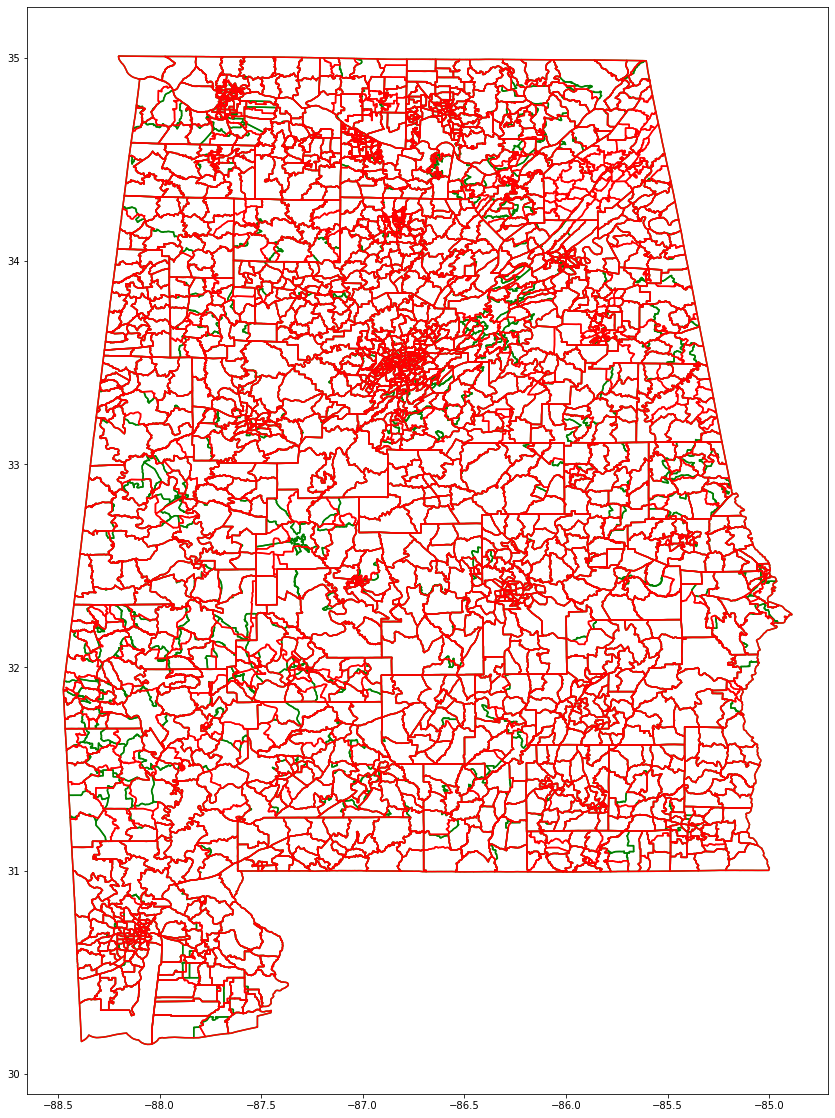

In [54]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(20,20),color="green")
vest_al_16.boundary.plot(figsize=(20,20),ax=ax,color="red")

### Shp from SOS

> Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.


See the README for the list of PDF maps that are available and the few contacts we made to counties. All of these counties do not have shapefiles available for download on their website, as of 6/8/2021.  